<a href="https://colab.research.google.com/github/IvanKatorgin/Deep-Learning/blob/main/Deep_Learning_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Deep Learning". Домашнее задание 3. Свёрточные сети. Каторгин И.П.

## Задание
Постройте модель, используя архитектуру со свёрточными слоями, для классификации Fashion MNIST. Итоговое качество (accuracy) должно быть не ниже 89,5.

Инструкция к выполнению задания
1. Скачайте тренировочную и тестовою часть датасета Fashion MNIST
2. Постройте архитектуру модели, используя свёрточные слои, слои регуляризации и один финальный полносвязный слой
3. Обучите модель до необходимого качества. Если сеть не обучается до необходимого качества, попробуйте поменять архитектуру сети, варьируя параметры свёрток, количество каналов, количество свёрточных слоёв, слои регуляризации, тип оптимайзера и т. д.

In [1]:
# загрузим библиотеки
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, time, cv2
%matplotlib inline

In [2]:
import torch
import torchvision as tv
from torch import autograd

In [3]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split, DataLoader

Загрузим датасет

In [4]:
BATCH_SIZE=256

In [5]:
transforms = tv.transforms.Compose([
    tv.transforms.Resize(28),
    tv.transforms.ToTensor()
])

In [6]:
# загрузим датасет
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=transforms, download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=transforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.83MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 57.6MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.31MB/s]


In [7]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [8]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

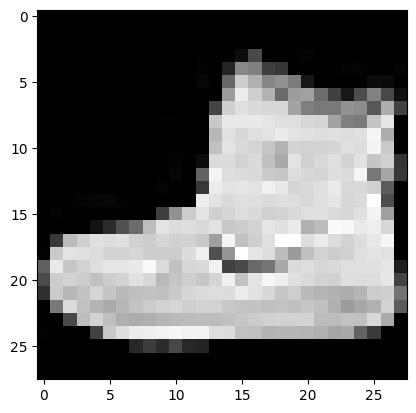

In [9]:
plt.imshow(train_dataset[0][0].numpy().reshape(28,28), cmap='gray');

Создадим модель

In [44]:
# старая модель, на ней не считаем. Она только для примера. На ее основе создаем новую модель (см. строчку кода ниже)
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=4, padding=0),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=4),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(16, 120, kernel_size=4),
    nn.Flatten(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10)
)

In [66]:
# улучшим модель
model = nn.Sequential(
    nn.Conv2d(1, 28, kernel_size=3, padding=1),
    nn.BatchNorm2d(28),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(28, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 120),
    nn.BatchNorm1d(120),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(120, 10)
)

In [67]:
from torchsummary import summary

summary(model, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 28, 28]             280
       BatchNorm2d-2           [-1, 28, 28, 28]              56
              ReLU-3           [-1, 28, 28, 28]               0
         MaxPool2d-4           [-1, 28, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          16,192
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
           Flatten-9                 [-1, 3136]               0
           Linear-10                  [-1, 120]         376,440
      BatchNorm1d-11                  [-1, 120]             240
             ReLU-12                  [-1, 120]               0
          Dropout-13                  [-1, 120]               0
           Linear-14                   

In [ ]:
# старая версия кода для старой модели, для новой модели см. строчку кода ниже
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

In [68]:
# новая версия кода
model.eval()  # Важно!
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
with torch.no_grad():
    for l in model:
        X = l(X)
        print(f"Layer {l}. X shape: {X.shape}")

Layer Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)). X shape: torch.Size([1, 28, 28, 28])
Layer BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True). X shape: torch.Size([1, 28, 28, 28])
Layer ReLU(). X shape: torch.Size([1, 28, 28, 28])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 28, 14, 14])
Layer Conv2d(28, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)). X shape: torch.Size([1, 64, 14, 14])
Layer BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True). X shape: torch.Size([1, 64, 14, 14])
Layer ReLU(). X shape: torch.Size([1, 64, 14, 14])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 64, 7, 7])
Layer Flatten(start_dim=1, end_dim=-1). X shape: torch.Size([1, 3136])
Layer Linear(in_features=3136, out_features=120, bias=True). X shape: torch.Size([1, 120])
Layer BatchNorm1d(120, eps=1e-05,

In [69]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
y = model(X)
print(y.shape)

torch.Size([1, 10])


In [70]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = torch.Tensor([0]), 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [71]:
def train(net, train_iter, test_iter, optimizer, num_epochs):
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for X, y in train_iter:
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

        test_acc = evaluate_accuracy(test_iter, net)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [72]:
lr, num_epochs = 0.001, 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
train(model, train_iter, test_iter, optimizer, num_epochs)

epoch 1, loss 0.0023, train acc 0.793, test acc 0.847, time 64.3 sec
epoch 2, loss 0.0014, train acc 0.873, test acc 0.868, time 67.6 sec
epoch 3, loss 0.0012, train acc 0.889, test acc 0.877, time 70.4 sec
epoch 4, loss 0.0011, train acc 0.900, test acc 0.883, time 67.3 sec
epoch 5, loss 0.0010, train acc 0.907, test acc 0.889, time 67.3 sec
epoch 6, loss 0.0009, train acc 0.914, test acc 0.893, time 66.1 sec
epoch 7, loss 0.0009, train acc 0.920, test acc 0.898, time 84.0 sec
epoch 8, loss 0.0008, train acc 0.925, test acc 0.902, time 117.0 sec
epoch 9, loss 0.0008, train acc 0.930, test acc 0.903, time 117.9 sec
epoch 10, loss 0.0007, train acc 0.934, test acc 0.907, time 117.4 sec


Итоговое качество (test acc) превысило 90. Но модель считается долго. Попробуем оптимизировать, а также посчитаем на **GPU**

In [77]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [78]:
model = model.to(device)

In [79]:
def train(net, train_iter, test_iter, optimizer, num_epochs, device):
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

        test_acc = evaluate_accuracy(test_iter, net, device)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [80]:
def evaluate_accuracy(data_iter, net, device):
    acc_sum, n = torch.Tensor([0]).to(device), 0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [81]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.0007, train acc 0.937, test acc 0.904, time 10.2 sec
epoch 2, loss 0.0006, train acc 0.941, test acc 0.902, time 10.9 sec
epoch 3, loss 0.0006, train acc 0.945, test acc 0.897, time 9.4 sec
epoch 4, loss 0.0005, train acc 0.950, test acc 0.901, time 9.9 sec
epoch 5, loss 0.0005, train acc 0.955, test acc 0.902, time 10.0 sec
epoch 6, loss 0.0004, train acc 0.960, test acc 0.905, time 10.1 sec
epoch 7, loss 0.0004, train acc 0.963, test acc 0.905, time 10.0 sec
epoch 8, loss 0.0004, train acc 0.961, test acc 0.905, time 9.6 sec
epoch 9, loss 0.0004, train acc 0.961, test acc 0.908, time 9.9 sec
epoch 10, loss 0.0004, train acc 0.966, test acc 0.912, time 9.9 sec


После оптимизации модель стала считаться значительно быстрее

Выводы:
1. Построена модель сверточной нейронной сети
2. Модель была обучена двумя способами
3. Test acc в обоих случаях превысил 0,9